# Project 2 Part A

## Dataset information

This dataset provides ground-truth class labels to evaluate performance of multi-instance learning models on both instance-level and bag-level label predictions. DeliciousMIL was first used to evaluate performance of MLTM, a multi-label multi-instance learning method, for document classification and sentence labeling.

Multi-instance learning is a special class of weakly supervised machine learning methods where the learner receives a collection of labeled bags each containing multiple instances. A bag is set to have a particular class label if and only if at least one of its instances has that class label.

DeliciousMIL consists of a subset of tagged web pages from the social bookmarking site delicious.com. The original web pages were obtained from DeliciousT140 dataset, which was collected from the delicious.com in June 2008. Users of the website delicious.com bookmarked each page with word tags. From this dataset, we extracted text parts of each web page and chose 20 common tags as class labels. These class labels are:
reference, design, programming, internet, computer, web, java, writing, English, grammar, style, language, books, education, philosophy, politics, religion, science, history, and culture.

We randomly selected 12234 pages and randomly divided them into 8251 training and 3983 test documents. We also applied Porter stemming and standard stopword removal.

Each text document is a bag within a multi-instance learning framework consisting of multiple sentences (instances). The goal is to predict document-level and sentence-level class labels on the test set using a model which is trained given only the document-level class labels in the training set.
To evaluate performance of such a model, we have manually labeled 1468 randomly selected sentences from the test documents.

## Loading Libraries

In [14]:
import warnings

import seaborn as sns
from keras.preprocessing import *
from sklearn.metrics import make_scorer
from sklearn.multiclass import OneVsRestClassifier
from wordcloud import WordCloud

from utils import *
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
X_train, y_train, X_test, y_test = load_dataset(maxlen=200)

Loading data...
8251 train sequences
3983 test sequences
X_train shape: (8251, 200)
X_test shape: (3983, 200)


### Plot the label distribution histogram

(-0.5, 799.5, 399.5, -0.5)

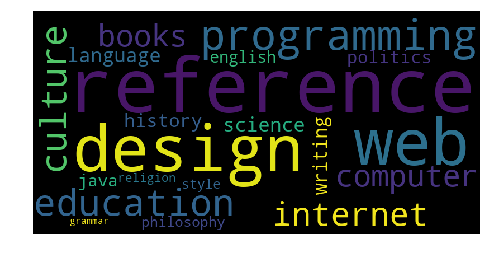

In [4]:
test = np.transpose(y_train)
cumsum = np.sum(test,axis=1)

labelsdict = {labels[i]:cumsum[i] for i in range(len(labels))}
cloud = WordCloud(width=800, height=400).generate_from_frequencies(labelsdict)
plt.figure(figsize=(8,8))
plt.imshow(cloud)
plt.axis('off')

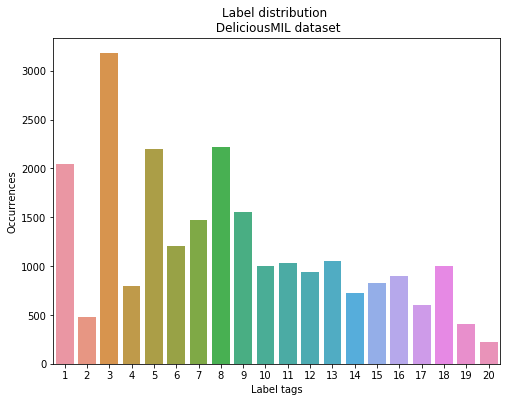

In [6]:
ind = np.arange(1, len(labels)+1)
plt.figure(figsize=(8,6))
sns.barplot(ind,cumsum)
plt.xlabel('Label tags')
plt.ylabel('Occurrences')
plt.title("Label distribution \n DeliciousMIL dataset")
plt.show()

In [9]:
# Display distribution of tags
for key,value in zip(labelsdict.keys(),labelsdict.values()):
    print('Tag : %s ,Frequency : %.f' %(key,value))

Tag : programming ,Frequency : 2050
Tag : style ,Frequency : 479
Tag : reference ,Frequency : 3181
Tag : java ,Frequency : 799
Tag : web ,Frequency : 2203
Tag : internet ,Frequency : 1211
Tag : culture ,Frequency : 1471
Tag : design ,Frequency : 2221
Tag : education ,Frequency : 1559
Tag : language ,Frequency : 1004
Tag : books ,Frequency : 1034
Tag : writing ,Frequency : 939
Tag : computer ,Frequency : 1049
Tag : english ,Frequency : 725
Tag : politics ,Frequency : 830
Tag : history ,Frequency : 898
Tag : philosophy ,Frequency : 598
Tag : science ,Frequency : 1001
Tag : religion ,Frequency : 411
Tag : grammar ,Frequency : 224


# Applying Methods

We need to pass our classifiers in an Multioutput wrapper in order to be able to make the random search

The multioutput strategy consists of fitting one classifier per target. This is a simple strategy for extending classifiers that do not natively support multi-target classification

### Define Classifiers and Scoring

In [7]:
scoring = {'Hamming Loss':make_scorer(hamming_loss),'Accuracy':make_scorer(accuracy_score)}

methods = ['CC','RAkEL','BinaryRelevance']

### Random Search for finding hyperparameters


In [4]:
for method in methods:
    pipeline(method,X_train,y_train,scoring,search_r=True)

Fitting Classifiers Chain pipeline...

Estimator: Logistic Regression
Best parameters found for Estimator : Logistic Regression
{'base_estimator__C': 25.87583368114379}

Best score found for Hamming Loss Score metric : 0.150

Estimator: Decision Tree Classifier
Best parameters found for Estimator : Decision Tree Classifier
{'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 20, 'base_estimator__max_features': 173, 'base_estimator__min_samples_split': 20}

Best score found for Hamming Loss Score metric : 0.212

Estimator: Gaussian NaiveBayes
Best parameters found for Estimator : Gaussian NaiveBayes
{'base_estimator__var_smoothing': 2.957784205237788e-06}

Best score found for Hamming Loss Score metric : 0.431
Fitting RAkEL pipeline...

Estimator: Logistic Regression
Best parameters found for Estimator : Logistic Regression
{'base_classifier__C': 5.405468696795974}

Best score found for Hamming Loss Score metric : 0.158

Estimator: Decision Tree Classifier
Best parameters 

### Grid Search for finding best hyperparameters

Define Hyperparameters for Grid search for each method and classifier respectively

In [4]:
# Parameters for classifier chains
params_tree_cc = {'__max_depth': [24,25,26],
               '__max_features': [176,177,178,179],
               '__min_samples_split': [18,19,20,21],
               '__criterion': ['gini']}
params_lgr_cc = {'__C':[25.0,25,6,24.8]}
params_nb_cc = {'__var_smoothing': [1e-6,3e-6,4e-6]}
params_cc = [params_tree_cc,params_lgr_cc,params_nb_cc]

#Parameters for RAkEL
params_tree_rk = {'__max_depth': [18,17,16],
               '__max_features': [176,177,178,180],
               '__min_samples_split': [278,276,275,274],
               '__criterion': ['gini']}
params_lgr_rk = {'__C':[7,6,6.5,4]}
params_nb_rk = {'__var_smoothing': [1e-6,3e-6,4e-6]}
params_rk = [params_tree_rk,params_lgr_rk,params_nb_rk]


#Parameters for LabelPowersets
params_tree_lb = {'__max_depth': [18,16,14],
               '__max_features': [105,104,103,102],
               '__min_samples_split': [18,19,20,21],
               '__criterion': ['gini']}
params_lgr_lb = {'__C':[78,77,76,74]}
params_nb_lb = {'__var_smoothing': [1e-7,3e-6,4e-6]}
params_lb = [params_tree_lb,params_lgr_lb,params_nb_lb]



params_search = [params_cc,params_rk,params_lb]


In [11]:
for method,params in zip(methods,params_search):
    pipeline(method,X_train,y_train,scoring,params,search_r=False)

Fitting Classifiers Chain pipeline...

Estimator: Logistic Regression
Best parameters found for Estimator : Logistic Regression
{'base_estimator__C': 25.0}

Best score found for Hamming Loss Score metric : 0.150

Estimator: Decision Tree Classifier
Best parameters found for Estimator : Decision Tree Classifier
{'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 24, 'base_estimator__max_features': 175, 'base_estimator__min_samples_split': 19}

Best score found for Hamming Loss Score metric : 0.221

Estimator: Gaussian NaiveBayes
Best parameters found for Estimator : Gaussian NaiveBayes
{'base_estimator__var_smoothing': 1e-06}

Best score found for Hamming Loss Score metric : 0.428
Fitting RAkEL pipeline...

Estimator: Logistic Regression
Best parameters found for Estimator : Logistic Regression
{'base_classifier__C': 7.0}

Best score found for Hamming Loss Score metric : 0.159

Estimator: Decision Tree Classifier
Best parameters found for Estimator : Decision Tree Classif

### Classifier Chains

Define classifiers with best hyperparameters

In [8]:
base_lr = LogisticRegression(solver='lbfgs',C=25.0,n_jobs=-1)
base_dt = DecisionTreeClassifier(max_depth=24,max_features=175,min_samples_split=19)
base_nb = GaussianNB(var_smoothing=1e-6)
clfs = {'Logistic Regression':base_lr,'DecisionTreeClassifier':base_dt,'GaussianNB':base_nb}

evaluate = ['acc','hamming_loss','f1_micro','f1_macro','prec_micro','prec_macro']

Finding independent Scores for Classifiers with OvR strategy

In [9]:
ind_scores = {}
for clf,key in zip(clfs.values(),clfs.keys()):
    print('Fitting indepedent %s' %key)
    wrapper = OneVsRestClassifier(clf,n_jobs=-1)
    wrapper.fit(X_train,y_train)
    preds = wrapper.predict(X_test)
    
    for m in evaluate:
        ind_scores[key+ ' ' +m] = (scores(m,y_test,preds))

Fitting indepedent Logistic Regression
Fitting indepedent DecisionTreeClassifier
Fitting indepedent GaussianNB


In [10]:
metrics_cc = CC_Fit(clfs,X_train,y_train,X_test,y_test,evaluate)

Fitting Chain Logistic Regression
Fitting Chain DecisionTreeClassifier
Fitting Chain GaussianNB


#### Plotting Results

In [11]:
model_names = ('Indepedent','Chain 1','Chain 2','Chain 3','Chain 4','Chain 5','Chain 6',
               'Chain 7','Chain 8','Chain 9','Chain 10','Ensemble')

Maximum Hamming Loss Classifier Chain Logistic Regression 0.1496


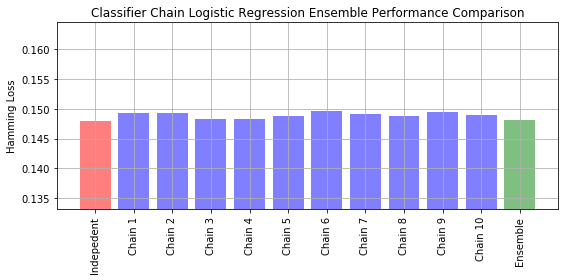

Maximum Hamming Loss Classifier Chain DecisionTreeClassifier 0.2164


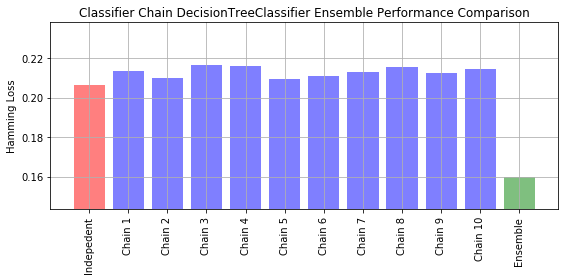

Maximum Hamming Loss Classifier Chain GaussianNB 0.4434


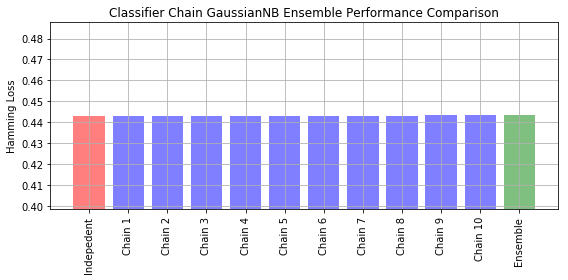

In [12]:
CC_plots(model_names,clfs,metrics_cc,ind_scores)

### RAkEL

In [13]:
base_lr = LogisticRegression(solver='lbfgs',C=7.0,n_jobs=-1)
base_dt = DecisionTreeClassifier(max_depth=18,max_features=180,min_samples_split=430)
base_nb = GaussianNB(var_smoothing=4e-06)
clfs = {'Logistic Regression':base_lr,'DecisionTreeClassifier':base_dt,'GaussianNB':base_nb}

In [14]:
steps = np.arange(5,12) #Define label set size
metrics_rk = RAkEL_fit(clfs,steps,X_train,y_train,X_test,y_test)

Fitting RAkEL with Base Classifier: Logistic Regression
Fitting RAkEL with Base Classifier: DecisionTreeClassifier
Fitting RAkEL with Base Classifier: GaussianNB


#### Plotting Results

Maximum Hamming Loss RAkEL DecisionTreeClassifier 0.1577
Maximum Hamming Loss RAkEL Logistic Regression 0.2175
Maximum Hamming Loss RAkEL GaussianNB 0.4727


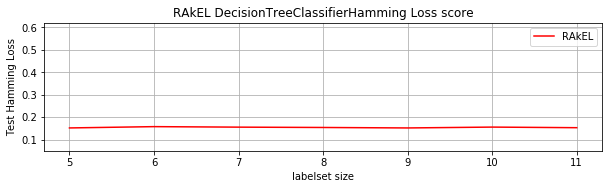

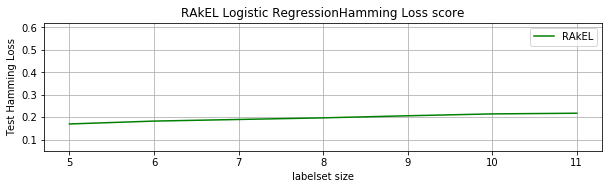

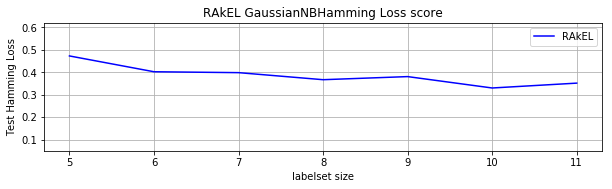

In [15]:
RAkEL_plots(steps,metrics_rk)

### Label Powersets

In [16]:
base_lr = LogisticRegression(solver='lbfgs',C=78,n_jobs=-1)
base_dt = DecisionTreeClassifier(max_depth=18,max_features=105,min_samples_split=278)
base_nb = GaussianNB(var_smoothing=1e-07)
clfs = {'Logistic Regression':base_lr,'DecisionTreeClassifier':base_dt,'GaussianNB':base_nb}

In [21]:
metrics_lb = LB_fit(clfs,X_train,y_train,X_test,y_test,evaluate)

Fitting Label Powerset with Classifier : Logistic Regression
Fitting Label Powerset with Classifier : DecisionTreeClassifier
Fitting Label Powerset with Classifier : GaussianNB


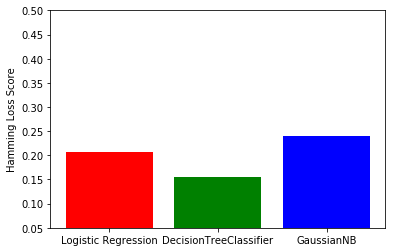

Maximum Score with Label Powersets 0.2393 GaussianNB


In [25]:
scores = np.array([metrics_lb['Logistic Regression hamming_loss'],metrics_lb['DecisionTreeClassifier hamming_loss'],
         metrics_lb['GaussianNB hamming_loss']])
names = ['Logistic Regression', 'DecisionTreeClassifier', 'GaussianNB']
LB_plots(scores,names)

# Final Results and Conclusions

Below is the final results that concluded with our algorithms

In [16]:
# final_results(metrics_cc,metrics_rk,metrics_lb,evaluate,names) Used that function to produce them and then load them
final_res = pd.read_pickle('C:/Users/User/Desktop/draft2/final_res.pkl')
final_res

,acc,f1_macro,f1_micro,hamming_loss,prec_macro,prec_micro
Logistic Regreesion CC,0.048958,0.013452,0.031986,0.148167,0.119451,0.318627
Logistic Regression RAkEL,0.039418,0.064883,0.083814,0.169608,0.155077,0.195199
Logistic Regression LabelPowerset,0.014813,0.140073,0.191159,0.206729,0.163825,0.221665
DecisionTreeClassifier CC,0.036405,0.072913,0.138081,0.159541,0.238621,0.321745
DecisionTreeClassifier RAkEL,0.039920,0.034688,0.084997,0.151896,0.162194,0.342057
DecisionTreeClassifier LabelPowerset,0.051971,0.032969,0.063607,0.155235,0.175084,0.258462
GaussianNB CC,0.001004,0.221303,0.240650,0.443246,0.154597,0.160233
GaussianNB RAkEL,0.000000,0.205202,0.226862,0.472734,0.146510,0.148814
GaussianNB LabelPowerset,0.002762,0.145872,0.201483,0.239305,0.154102,0.195656


In [17]:
best_results(final_res)

Best acc found : 0.0520 with classifier and method :DecisionTreeClassifier LabelPowerset
Best f1_macro found : 0.2213 with classifier and method :GaussianNB CC
Best f1_micro found : 0.2407 with classifier and method :GaussianNB CC
Best hamming_loss found : 0.4727 with classifier and method :GaussianNB RAkEL
Best prec_macro found : 0.2386 with classifier and method :DecisionTreeClassifier CC
Best prec_micro found : 0.3421 with classifier and method :DecisionTreeClassifier RAkEL


As we see here the best score we got was with the Hamming Loss metric and that was obtained with the method Random k Labelsets and classifier Gaussian Naive Bayes.Judging by our dataset that is a pretty optimistic result 